In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import (binary_erosion, binary_dilation, binary_closing, 
                          binary_opening, label, generate_binary_structure)
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 1. СОЗДАЁМ СИНТЕТИЧЕСКОЕ ИЗОБРАЖЕНИЕ

np.random.seed(42)
size = 300

# Создаём RGB изображение (спутниковый снимок)
img = np.zeros((size, size, 3), dtype=np.uint8)

# Фон - разнообразный ландшафт
# Лес/поля (зеленоватые тона)
for i in range(size):
    for j in range(size):
        # Базовый ландшафт с вариациями
        if i < 150:  # верхняя часть - более зелёная
            img[i, j, 0] = 70 + np.random.normal(0, 15)   # R
            img[i, j, 1] = 120 + np.random.normal(0, 20)  # G
            img[i, j, 2] = 80 + np.random.normal(0, 10)   # B
        else:  # нижняя часть - более коричневая
            img[i, j, 0] = 130 + np.random.normal(0, 20)  # R
            img[i, j, 1] = 100 + np.random.normal(0, 15)  # G
            img[i, j, 2] = 80 + np.random.normal(0, 15)   # B


# 2. ДОБАВЛЯЕМ ВОДНЫЕ ОБЪЕКТЫ (ЦЕЛЬ ДЛЯ ОБНАРУЖЕНИЯ)


# Функция для добавления водоёма
def add_water_body(img, center_x, center_y, radius, shape='circle'):
    """Добавляет водоём на изображение"""
    for i in range(max(0, center_x-radius-5), min(size, center_x+radius+5)):
        for j in range(max(0, center_y-radius-5), min(size, center_y+radius+5)):
            dist = np.sqrt((i - center_x)**2 + (j - center_y)**2)
            
            if shape == 'circle' and dist < radius:
                # Вода - синяя, гладкая
                img[i, j, 0] = 30 + np.random.normal(0, 5)   # мало красного
                img[i, j, 1] = 50 + np.random.normal(0, 5)   # мало зелёного
                img[i, j, 2] = 200 + np.random.normal(0, 8)  # много синего
                
            elif shape == 'lake' and dist < radius * (0.8 + 0.2 * np.sin(j/10)):
                # Неправильная форма озера
                if dist < radius * (0.8 + 0.2 * np.sin(j/10)):
                    img[i, j, 0] = 25 + np.random.normal(0, 5)
                    img[i, j, 1] = 45 + np.random.normal(0, 5)
                    img[i, j, 2] = 210 + np.random.normal(0, 8)

# Добавляем несколько водоёмов
add_water_body(img, 80, 80, 25, 'circle')      # круглое озеро
add_water_body(img, 200, 150, 35, 'lake')      # озеро неправильной формы
add_water_body(img, 120, 220, 20, 'circle')    # маленькое озеро

# Добавляем реку (линейный объект)
for i in range(180, 250):
    for j in range(200, 250):
        # Извилистая река
        river_edge = 220 + 10 * np.sin(i/15)
        if abs(j - river_edge) < 4:
            img[i, j, 0] = 20 + np.random.normal(0, 4)
            img[i, j, 1] = 40 + np.random.normal(0, 4)
            img[i, j, 2] = 200 + np.random.normal(0, 6)

# Добавляем объекты-ловушки (ложные цели)
# Тени (тёмные, гладкие - похожи на воду)
for i in range(40, 70):
    for j in range(150, 180):
        if (i-55)**2 + (j-165)**2 < 100:
            img[i, j, :] = 50 + np.random.normal(0, 8)  # тёмные тона

# Блестящая крыша (яркая, синеватая)
for i in range(220, 250):
    for j in range(50, 80):
        if abs(i-235) < 12 and abs(j-65) < 12:
            img[i, j, 0] = 180 + np.random.normal(0, 10)
            img[i, j, 1] = 190 + np.random.normal(0, 10)
            img[i, j, 2] = 210 + np.random.normal(0, 10)

# Влажная почва (тёмная, но не вода)
for i in range(150, 180):
    for j in range(260, 290):
        if (i-165)**2 + (j-275)**2 < 150:
            img[i, j, 0] = 60 + np.random.normal(0, 10)
            img[i, j, 1] = 55 + np.random.normal(0, 10)
            img[i, j, 2] = 70 + np.random.normal(0, 10)

# Нормируем
img = np.clip(img, 0, 255).astype(np.uint8)


# 3. СОЗДАЁМ ЭТАЛОННУЮ МАСКУ (ВОДА)

ground_truth = np.zeros((size, size), dtype=bool)

# Размечаем воду вручную (в реальности делается экспертом)
for i in range(size):
    for j in range(size):
        # Круглое озеро
        if (i-80)**2 + (j-80)**2 < 25**2:
            ground_truth[i, j] = True
        # Озеро неправильной формы
        if (i-200)**2 / 35**2 + (j-150)**2 / 40**2 < 1:
            ground_truth[i, j] = True
        # Маленькое озеро
        if (i-120)**2 + (j-220)**2 < 20**2:
            ground_truth[i, j] = True
        # Река
        river_pos = 220 + 10 * np.sin(i/15)
        if 180 <= i < 260 and abs(j - river_pos) < 4:
            ground_truth[i, j] = True


In [5]:
# 4. ПРАВИЛА ДЛЯ ОБНАРУЖЕНИЯ ВОДЫ


print("="*80)
print("ПРАВИЛА ОБНАРУЖЕНИЯ ВОДНЫХ ОБЪЕКТОВ")
print("="*80)

# Правило 1: Спектральное (синий канал доминирует)
blue_ratio = img[:, :, 2].astype(float) / (img.sum(axis=2) + 1)  # доля синего
rule1 = blue_ratio > 0.45
print("Правило 1: blue_ratio > 0.45 (спектральный признак)")

# Правило 2: Низкая яркость (вода обычно темнее)
brightness = img.mean(axis=2)
rule2 = brightness < 110
print("Правило 2: brightness < 110 (вода темнее)")

# Правило 3: Разность каналов (синий - красный)
blue_minus_red = img[:, :, 2].astype(float) - img[:, :, 0].astype(float)
rule3 = blue_minus_red > 80
print("Правило 3: blue_minus_red > 80")

# Правило 4: Текстурный признак (вода гладкая)
# Используем локальное стандартное отклонение как меру текстуры
def local_std(arr, window_size=5):
    """Вычисляет локальное стандартное отклонение"""
    from scipy.ndimage import uniform_filter
    c1 = uniform_filter(arr, window_size, mode='constant')
    c2 = uniform_filter(arr*arr, window_size, mode='constant')
    return np.sqrt(c2 - c1*c1)

texture = local_std(brightness, window_size=7)
rule4 = texture < 15  # гладкие области
print("Правило 4: texture < 15 (вода гладкая)")

# Правило 5: Форма (объекты должны быть достаточно большими)



# 5. КОМБИНИРОВАНИЕ ПРАВИЛ


print("\n" + "="*80)
print("КОМБИНИРОВАНИЕ ПРАВИЛ")
print("="*80)

# Разные стратегии комбинирования
# Стратегия A: Все правила И
combined_and = rule1 & rule2 & rule3 & rule4
print("Стратегия A (И): все правила должны выполняться")

# Стратегия B: Голосование (минимум 3 из 4)
votes = rule1.astype(int) + rule2.astype(int) + rule3.astype(int) + rule4.astype(int)
combined_vote = votes >= 3
print("Стратегия B (ГОЛОСОВАНИЕ): минимум 3 правила из 4")

# Стратегия C: Взвешенная (с приоритетом спектральных правил)
weighted_score = (rule1.astype(float) * 0.4 + 
                  rule2.astype(float) * 0.2 +
                  rule3.astype(float) * 0.3 + 
                  rule4.astype(float) * 0.1)
combined_weighted = weighted_score > 0.5
print("Стратегия C (ВЗВЕШЕННАЯ): спектральные правила важнее")

# Выбираем лучшую стратегию (для демо возьмём взвешенную)
water_candidates = combined_weighted.copy()


# 6. МОРФОЛОГИЧЕСКАЯ ПОСТ-ОБРАБОТКА


print("\n" + "="*80)
print("МОРФОЛОГИЧЕСКАЯ ОБРАБОТКА")
print("="*80)

# Структурный элемент
struct = generate_binary_structure(2, 1)

# Шаг 1: Убираем мелкий шум (открытие)
water_opened = binary_opening(water_candidates, structure=struct, iterations=2)
print("Шаг 1: Открытие (удаление мелкого шума)")

# Шаг 2: Заполняем дыры (закрытие)
water_closed = binary_closing(water_opened, structure=struct, iterations=2)
print("Шаг 2: Закрытие (заполнение дыр)")

# Шаг 3: Удаляем объекты меньше заданного размера
labeled, num_features = label(water_closed)
water_filtered = np.zeros_like(water_closed)
min_object_size = 100  # минимальный размер в пикселях

for i in range(1, num_features + 1):
    if np.sum(labeled == i) > min_object_size:
        water_filtered[labeled == i] = True

print(f"Шаг 3: Удалены объекты меньше {min_object_size} пикселей")
print(f"   Было объектов: {num_features}, стало: {len(np.unique(labeled[water_filtered])) - (0 if water_filtered.sum()>0 else 1)}")

# Финальная маска
final_mask = water_filtered

ПРАВИЛА ОБНАРУЖЕНИЯ ВОДНЫХ ОБЪЕКТОВ
Правило 1: blue_ratio > 0.45 (спектральный признак)
Правило 2: brightness < 110 (вода темнее)
Правило 3: blue_minus_red > 80
Правило 4: texture < 15 (вода гладкая)

КОМБИНИРОВАНИЕ ПРАВИЛ
Стратегия A (И): все правила должны выполняться
Стратегия B (ГОЛОСОВАНИЕ): минимум 3 правила из 4
Стратегия C (ВЗВЕШЕННАЯ): спектральные правила важнее

МОРФОЛОГИЧЕСКАЯ ОБРАБОТКА
Шаг 1: Открытие (удаление мелкого шума)
Шаг 2: Закрытие (заполнение дыр)
Шаг 3: Удалены объекты меньше 100 пикселей
   Было объектов: 4, стало: 4


In [6]:
# 7. ОЦЕНКА КАЧЕСТВА


def calculate_metrics(gt, pred):
    """Вычисляет метрики качества"""
    gt_flat = gt.flatten()
    pred_flat = pred.flatten()
    
    tp = np.sum((gt_flat == 1) & (pred_flat == 1))
    tn = np.sum((gt_flat == 0) & (pred_flat == 0))
    fp = np.sum((gt_flat == 0) & (pred_flat == 1))
    fn = np.sum((gt_flat == 1) & (pred_flat == 0))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'iou': iou,
        'f1': f1,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

# Оцениваем на разных этапах
metrics_raw = calculate_metrics(ground_truth, water_candidates)
metrics_final = calculate_metrics(ground_truth, final_mask)

print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ ОБНАРУЖЕНИЯ")
print("="*80)
print(f"\n--- До морфологической обработки ---")
print(f"Accuracy:  {metrics_raw['accuracy']:.3f}")
print(f"Precision: {metrics_raw['precision']:.3f}")
print(f"Recall:    {metrics_raw['recall']:.3f}")
print(f"IoU:       {metrics_raw['iou']:.3f}")
print(f"F1-score:  {metrics_raw['f1']:.3f}")

print(f"\n--- После морфологической обработки ---")
print(f"Accuracy:  {metrics_final['accuracy']:.3f}")
print(f"Precision: {metrics_final['precision']:.3f}")
print(f"Recall:    {metrics_final['recall']:.3f}")
print(f"IoU:       {metrics_final['iou']:.3f}")
print(f"F1-score:  {metrics_final['f1']:.3f}")

# ============================================
# 8. АНАЛИЗ ОШИБОК
# ============================================

false_positives = final_mask & ~ground_truth
false_negatives = ~final_mask & ground_truth
true_positives = final_mask & ground_truth

print("\n" + "="*80)
print("АНАЛИЗ ОШИБОК")
print("="*80)
print(f"Истинно-положительные: {metrics_final['tp']} пикселей")
print(f"Ложноположительные:    {metrics_final['fp']} пикселей")
print(f"Ложноотрицательные:    {metrics_final['fn']} пикселей")

# Находим отдельные объекты-ошибки
fp_labels, fp_count = label(false_positives)
fn_labels, fn_count = label(false_negatives)

print(f"\nОтдельные ложноположительные объекты: {fp_count}")
print(f"Отдельные ложноотрицательные объекты: {fn_count}")


РЕЗУЛЬТАТЫ ОБНАРУЖЕНИЯ

--- До морфологической обработки ---
Accuracy:  0.977
Precision: 0.992
Recall:    0.750
IoU:       0.745
F1-score:  0.854

--- После морфологической обработки ---
Accuracy:  0.977
Precision: 1.000
Recall:    0.748
IoU:       0.748
F1-score:  0.856

АНАЛИЗ ОШИБОК
Истинно-положительные: 6134 пикселей
Ложноположительные:    0 пикселей
Ложноотрицательные:    2071 пикселей

Отдельные ложноположительные объекты: 0
Отдельные ложноотрицательные объекты: 9


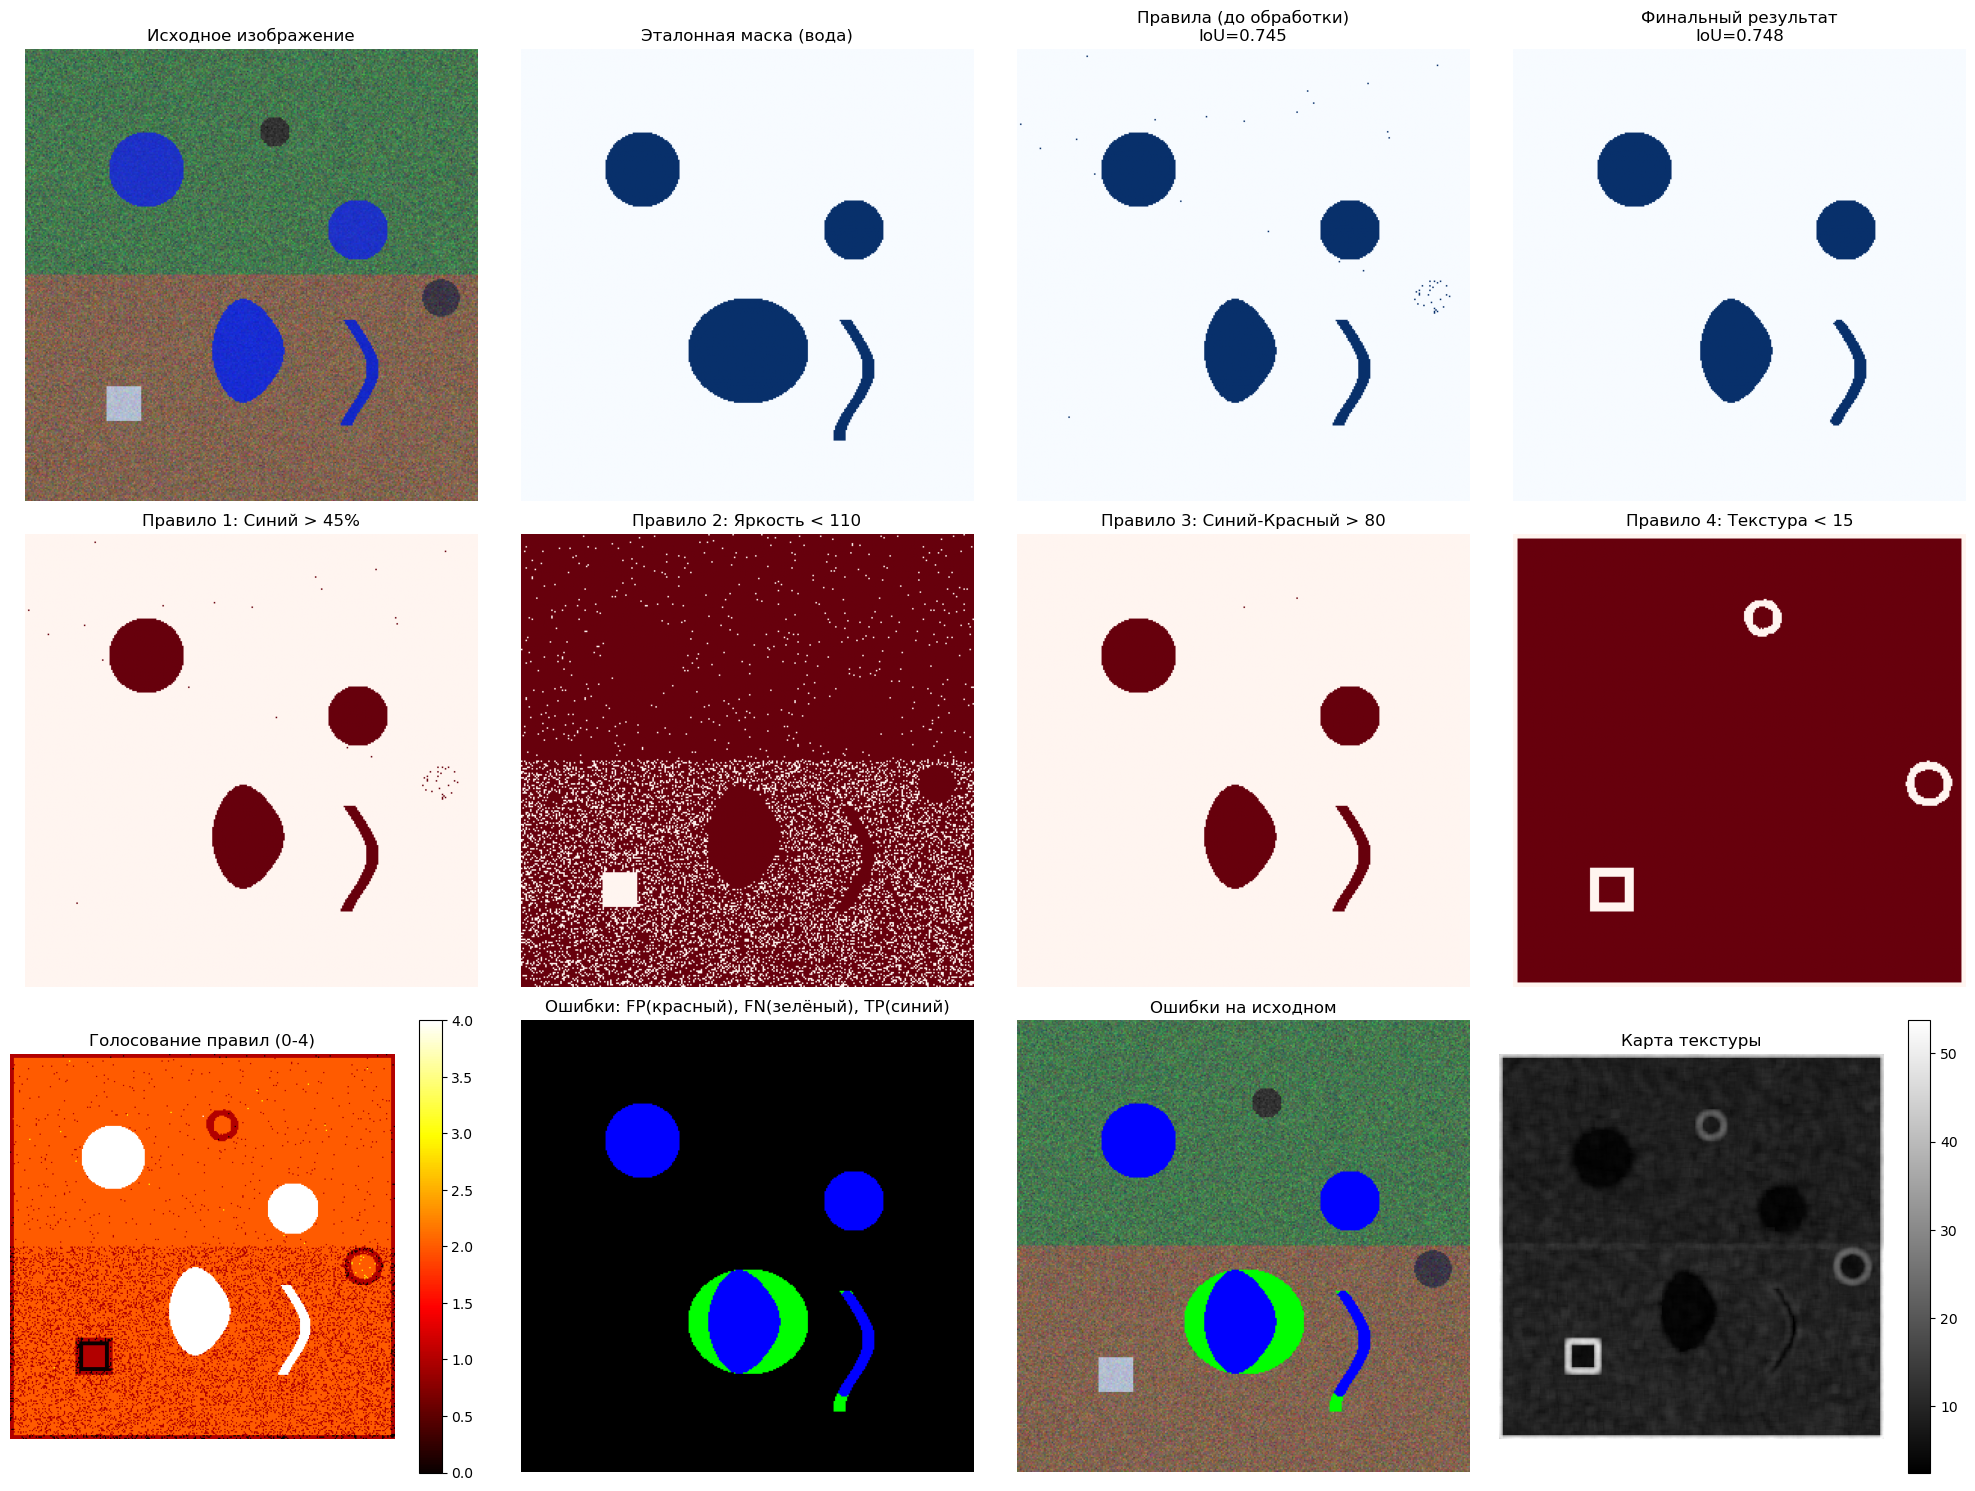

In [8]:
# 9. ВИЗУАЛИЗАЦИЯ


fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# 1. Исходное изображение
axes[0, 0].imshow(img)
axes[0, 0].set_title('Исходное изображение')
axes[0, 0].axis('off')

# 2. Эталонная маска
axes[0, 1].imshow(ground_truth, cmap='Blues')
axes[0, 1].set_title('Эталонная маска (вода)')
axes[0, 1].axis('off')

# 3. Результат правил (до обработки)
axes[0, 2].imshow(water_candidates, cmap='Blues')
axes[0, 2].set_title(f'Правила (до обработки)\nIoU={metrics_raw["iou"]:.3f}')
axes[0, 2].axis('off')

# 4. Финальный результат
axes[0, 3].imshow(final_mask, cmap='Blues')
axes[0, 3].set_title(f'Финальный результат\nIoU={metrics_final["iou"]:.3f}')
axes[0, 3].axis('off')

# 5. Визуализация правил
axes[1, 0].imshow(rule1, cmap='Reds')
axes[1, 0].set_title('Правило 1: Синий > 45%')
axes[1, 0].axis('off')

axes[1, 1].imshow(rule2, cmap='Reds')
axes[1, 1].set_title('Правило 2: Яркость < 110')
axes[1, 1].axis('off')

axes[1, 2].imshow(rule3, cmap='Reds')
axes[1, 2].set_title('Правило 3: Синий-Красный > 80')
axes[1, 2].axis('off')

axes[1, 3].imshow(rule4, cmap='Reds')
axes[1, 3].set_title('Правило 4: Текстура < 15')
axes[1, 3].axis('off')

# 6. Голосование
axes[2, 0].imshow(votes, cmap='hot', vmin=0, vmax=4)
axes[2, 0].set_title('Голосование правил (0-4)')
axes[2, 0].axis('off')
plt.colorbar(axes[2, 0].images[0], ax=axes[2, 0])

# 7. Ошибки
error_rgb = np.zeros((size, size, 3), dtype=np.uint8)
error_rgb[..., 0] = false_positives * 255  # FP - красный
error_rgb[..., 1] = false_negatives * 255  # FN - зелёный
error_rgb[..., 2] = true_positives * 255   # TP - синий

axes[2, 1].imshow(error_rgb)
axes[2, 1].set_title('Ошибки: FP(красный), FN(зелёный), TP(синий)')
axes[2, 1].axis('off')

# 8. Наложение на исходное
overlay = img.copy()
overlay[false_positives] = [255, 0, 0]    # FP - красный
overlay[false_negatives] = [0, 255, 0]    # FN - зелёный
overlay[true_positives] = [0, 0, 255]     # TP - синий

axes[2, 2].imshow(overlay)
axes[2, 2].set_title('Ошибки на исходном')
axes[2, 2].axis('off')

# 9. Текстура (для информации)
axes[2, 3].imshow(texture, cmap='gray')
axes[2, 3].set_title('Карта текстуры')
axes[2, 3].axis('off')
plt.colorbar(axes[2, 3].images[0], ax=axes[2, 3])

plt.tight_layout()
plt.show()